In [1]:
!pwd

/Users/neku5162/Desktop/sir_inversions/2_line_run


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, UnivariateSpline
import time
from astropy.io import fits

In [3]:
def readsim(file):
    raw = np.loadtxt(file)
    return np.transpose(raw.reshape((64,252,252)))

In [4]:
sim_z = np.loadtxt('/Users/neku5162/Desktop/time_series/z_100.csv') *10.0**(5.0) # cgs units [sim_z is a global value of the simulation domain.]
dx = 23.809496*10.0**(5.0)
dy = 23.809496*10.0**(5.0)
dt = 10.0 # 10 second spacing between snapshots I could be wrong here....

mu = 1.2904  # from rh
kb = 1.38064852*10.0**(-16.0) # cgs 
amu = 1.660540*10**(-24.0) # cgs 
g = 27400.0 

In [5]:
sim_tau = np.log10(readsim('/Users/neku5162/Desktop/time_series/tau_100.csv')[:,:,1:])
sim_temp = readsim('/Users/neku5162/Desktop/time_series/t_100.csv')
sim_tau = np.append(np.zeros((252,252,1))-6.0,sim_tau,axis=2) ## append log tau = -6 at the start

In [6]:
raw_spectra = np.transpose(np.loadtxt('spectrum.csv').reshape((257,252,252)))

# Raw un-normalized spectra in CGS units

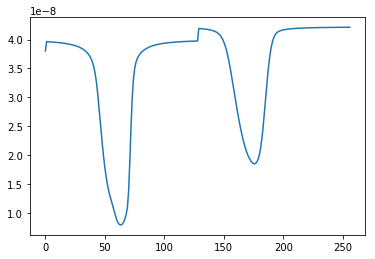

In [7]:
plt.plot(raw_spectra[4,4,:])

# Load in sim stuff 

In [8]:
tau_sir = np.loadtxt('pixels/0_0/guess.mod',skiprows=1)[:,0]
sim_temp_tau = np.loadtxt('sim_temp_tau.csv').reshape((252,252,len(tau_sir)))

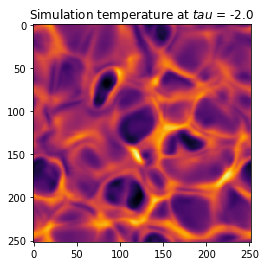

In [9]:
index = 40
plt.imshow(sim_temp_tau[:,:,index],cmap='inferno')
plt.title('Simulation temperature at $tau$ = ' + str(round(tau_sir[index],2)))
plt.show()

In [10]:
temp_inversions = np.loadtxt('myfile.dat')
t_sir = np.transpose(temp_inversions.reshape(252,252,64),axes=[1,0,2])

# Clustering

In [118]:
from sklearn.cluster import KMeans
kmeans_raw = KMeans(n_clusters=15,init = 'k-means++' , random_state=1).fit(raw_spectra.reshape((252*252,257)))


(array([6283., 4697., 5468., 3698., 4871., 4661., 3606., 1453., 2251.,
        1891., 3624., 4494., 3940., 7416., 5151.]),
 array([ 0.        ,  0.93333333,  1.86666667,  2.8       ,  3.73333333,
         4.66666667,  5.6       ,  6.53333333,  7.46666667,  8.4       ,
         9.33333333, 10.26666667, 11.2       , 12.13333333, 13.06666667,
        14.        ]),
 <a list of 15 Patch objects>)

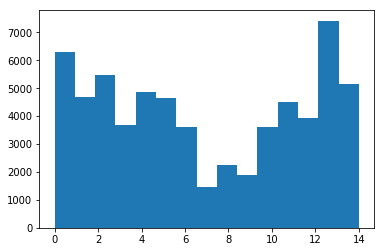

In [127]:
plt.hist(kmeans_raw.labels_,bins=15)

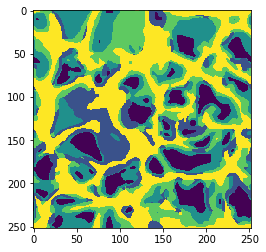

In [24]:
plt.imshow(kmeans_raw.labels_.reshape(252,252))

In [141]:
def tau_rms_diff(kmeans_class):
    
    spectr_cube = np.zeros((252,252,257))
    labels = kmeans_class.labels_.reshape(252,252)
    
    tau_centers = np.zeros((kmeans_class.n_clusters,64))

    # make tau cube
    for label in range(kmeans_class.n_clusters):
        x,y = np.where(labels==label)
        for instance in range(len(x)):
            tau_centers[label] += sim_tau[x[instance],y[instance]]
        tau_centers[label] /= len(x)  
    
    reconstructed_tau = np.zeros((252,252,64))
    for i in range(252):
        for j in range(252):
            reconstructed_tau[i,j] = tau_centers[labels[i,j]]
            
    return np.mean(np.abs(reconstructed_tau - sim_tau)/(np.abs(reconstructed_tau + sim_tau)*0.5))
    
    

In [142]:
def spec_rms_diff(kmeans_class):
    
    spectr_cube = np.zeros((252,252,257))
    labels = kmeans_class.labels_.reshape(252,252)
    
    for i in range(252):
        for j in range(252):
            spectr_cube[i,j] = kmeans_class.cluster_centers_[labels[i,j]]
            
    return np.sqrt(np.mean(((raw_spectra-spectr_cube)/raw_spectra)**2)) # rms error
    
    

In [143]:
n_clusters = [1,2,3,4,5,7,10,15,20,30,50,100]
kmeans_models = [KMeans(n_clusters=n,init = 'k-means++' , random_state=1).fit(raw_spectra.reshape((252*252,257))) 
                 for n in n_clusters]

In [144]:
spec_errs = [spec_rms_diff(kmeans_models[i]) for i in range(len(n_clusters))]
tau_errs = [tau_rms_diff(kmeans_models[i]) for i in range(len(n_clusters))]

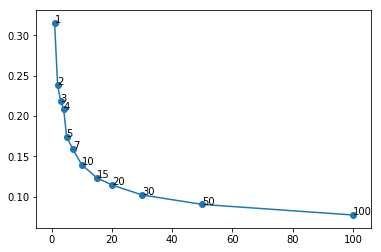

In [62]:
plt.plot(n_clusters,spec_errs)
plt.scatter(n_clusters,spec_errs)
for i, txt in enumerate(n_clusters):
    plt.annotate(txt, (n_clusters[i], spec_errs[i]))

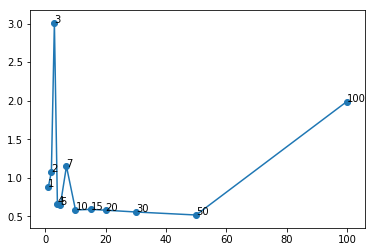

In [145]:
plt.plot(n_clusters,tau_errs)
plt.scatter(n_clusters,tau_errs)
for i, txt in enumerate(n_clusters):
    plt.annotate(txt, (n_clusters[i], tau_errs[i]))

### Keep it simple, cluster based off intensity at 500 nm alone. No need for any other fancy business...

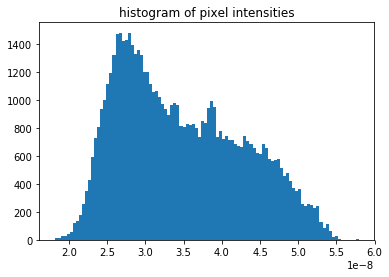

In [12]:
plt.hist(raw_spectra[:,:,0].flatten(),bins=100)
plt.title('histogram of pixel intensities')
plt.show()


# Plan: Divide up intensities at 500nm into partitions and interpolate between partitions in the tau vs z profiles

In [13]:
partitions = 5
i_bins = np.linspace(np.min(raw_spectra[:,:,0]),np.max(raw_spectra[:,:,0]), num = partitions)

In [14]:
# Array of keys which label each pixel according to bins

key_arr = np.zeros((252,252))
for i in np.arange(252):
    for j in np.arange(252):
        i_c =  raw_spectra[i,j,0]
        new = np.sort(np.append(i_c,i_bins))
        key_arr[i,j] = np.where(new == i_c)[0][0]
        
        

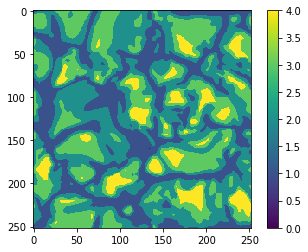

In [15]:
plt.imshow(key_arr)
plt.colorbar()

In [16]:
def median_tau(label):
    count = len(np.where(key_arr==label)[0])

    tau_arr = np.array([])

    for val in np.arange(count):
        i = np.where(key_arr==label)[0][val]
        j = np.where(key_arr==label)[1][val]
        tau_arr = np.append(tau_arr,sim_tau[i,j,:])
    
    tau_arr = tau_arr.reshape((count,64))
    
    return np.median(tau_arr,axis=0)



In [11]:
# mean tau
tau_clusters = np.zeros((partitions,64))
cluster_count = [len(np.where(key_arr==key)[0]) for key in np.arange(partitions)]

for i in np.arange(252):
    for j in np.arange(252):
        
            tau_clusters[int(key_arr[i,j])] += sim_tau[i,j,:]/cluster_count[int(key_arr[i,j])]

        
#for label in np.arange(partitions):
#    tau_clusters[label] = tau_clusters[label,:]/cluster_count[label]  # normalize by number of elements in each cluster


In [12]:
# # median tau
# tau_clusters = np.zeros((partitions,64))

# for label in np.arange(partitions):
#     tau_clusters[label] = median_tau(label)

### $\tau$ vs z profiles for each cluster and we can interpolate between them

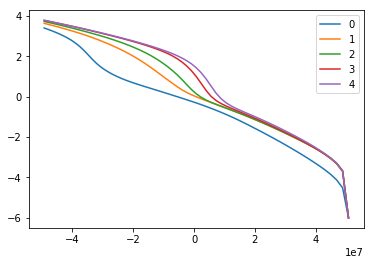

In [13]:
for label in np.arange(partitions):
    plt.plot(sim_z,tau_clusters[label,:],label = str(label))
plt.legend()

In [14]:
# Now we need to interpolate between the different tau vs z profiles 

In [15]:
i_bins

array([1.81217019e-08, 2.80807093e-08, 3.80397167e-08, 4.79987241e-08,
       5.79577315e-08])

In [16]:
def get_i_index(value):
    new_arr = np.sort(np.append(i_bins,value))
    return np.where(new_arr == value)[0][0]-1

# tau profiles are caculated by taking linear combintions of cluster profiles.

# the coefficients of the linear combination are determined by the relative distances from each pixel to the intensity bins

In [17]:
def get_tau(i_cont):
    c = get_i_index(i_cont) # cluster above which new index is between
#     print(i_bins[c])
#     print(i_bins[c+1])
    # calculate distances from binned values
    a = np.abs( i_bins[c]-i_cont) / ( i_bins[c+1]-i_bins[c])
    b = np.abs( i_bins[c+1]-i_cont) / ( i_bins[c+1]-i_bins[c])
#     print(a)
#     print(b)
    return a*tau_clusters[c] + b*tau_clusters[c+1]

In [18]:
i_bins

array([1.81217019e-08, 2.80807093e-08, 3.80397167e-08, 4.79987241e-08,
       5.79577315e-08])

In [19]:
cluster_count

[1, 16609, 25070, 17472, 4352]

5.168821454376278e-08
4.799872412703657e-08 5.795773153812352e-08


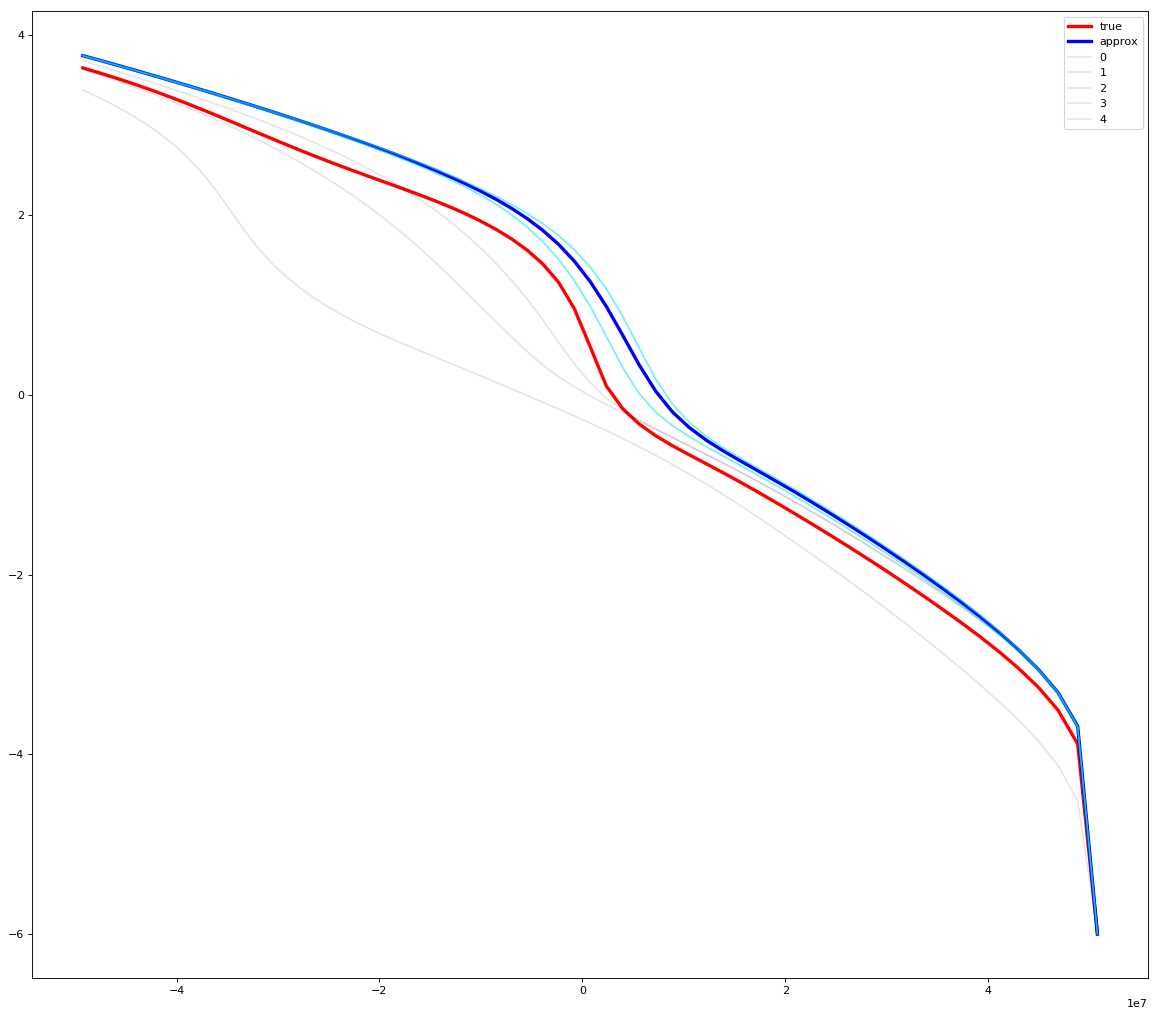

In [20]:
i = np.random.randint(252)
j = np.random.randint(252)

i_cont = raw_spectra[i,j,0]
print(i_cont)
print(i_bins[get_i_index(i_cont)],i_bins[get_i_index(i_cont)+1])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sim_z,sim_tau[i,j,:],label = 'true',color='red',linewidth = 3.0)
plt.plot(sim_z,get_tau(i_cont),label = 'approx',color='b',linewidth = 3.0)
for label in np.arange(partitions):
    plt.plot(sim_z,tau_clusters[label,:],label = str(label),alpha = 0.1,color = 'black')
plt.plot(sim_z,tau_clusters[get_i_index(i_cont),:],color = 'cyan',alpha =0.5)
plt.plot(sim_z,tau_clusters[get_i_index(i_cont)+1,:],color = 'cyan',alpha= 0.5)

plt.legend(bbox_to_anchor=[1.0, 5.0])

plt.legend()

# idea: How to determine bins such that they are 'uniform in tau(z) scale'?

In [24]:
tau_sir = np.loadtxt('pixels/0_0/guess.mod',skiprows=1)[:,0]
temp_inversions = np.loadtxt('myfile.dat')
t_sir = np.transpose(temp_inversions.reshape(252,252,64),axes=[1,0,2])

Text(0.5, 0, 'temp (K)')

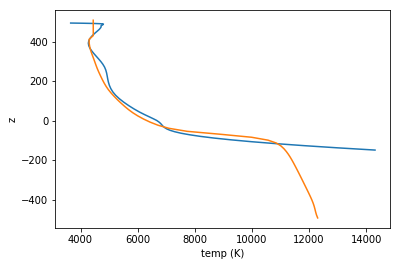

In [25]:
i = np.random.randint(252)
j = np.random.randint(252)
zoftau = interp1d(get_tau(raw_spectra[i,j,0]),sim_z*(1e-5),kind='linear')
plt.plot(t_sir[i,j,:],zoftau(tau_sir))
plt.plot(sim_temp[i,j,:],sim_z*(1e-5))
plt.ylabel('z')
plt.xlabel('temp (K)')

In [26]:
sir_z_temp = np.zeros((252,252,64))
for i in np.arange(252):
    for j in np.arange(252):
        #create interpolaing function for each pixel
        z_of_tau = interp1d(get_tau(raw_spectra[i,j,0]),sim_z*(1e-5),kind='linear',fill_value='extrapolate')

        t_of_z = interp1d(z_of_tau(tau_sir),t_sir[i,j,:],kind='linear',fill_value='extrapolate')
        
        sir_z_temp[i,j] = t_of_z(sim_z*(1e-5))

        

In [27]:
from sklearn.metrics import r2_score

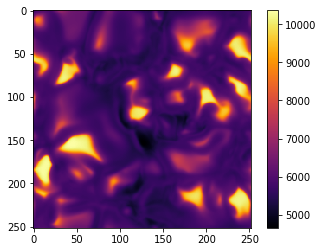

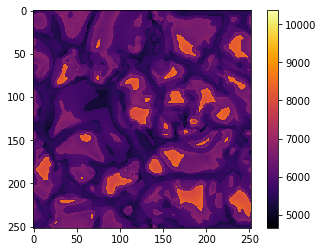

0.45475435406697473


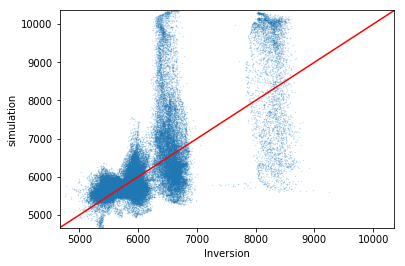

In [28]:
index = 25
plt.imshow(sim_temp[:,:,index],cmap='inferno')
cup = np.max(sim_temp[:,:,index])
clo = np.min(sim_temp[:,:,index])
plt.colorbar()
plt.clim(cup,clo)
plt.show()
plt.imshow(sir_z_temp[:,:,index],cmap='inferno')
plt.colorbar()
plt.clim(cup,clo)
plt.show()

plt.scatter(sir_z_temp[:,:,index].flatten(),sim_temp[:,:,index].flatten(),s=0.1,alpha=0.3)
t_range = np.linspace(np.min(sim_temp[:,:,index]),np.max(sim_temp[:,:,index]))
plt.plot(t_range,t_range,'red')
plt.xlim(np.min(sim_temp[:,:,index]),np.max(sim_temp[:,:,index]))
plt.ylim(np.min(sim_temp[:,:,index]),np.max(sim_temp[:,:,index]))

plt.xlabel('Inversion')
plt.ylabel('simulation')
print(r2_score(sim_temp[:,:,index].flatten(),sir_z_temp[:,:,index].flatten()))

# Double check code
# A problem is that the mean/median profile is not very representative of some of the profiles which vary more rapidly in a less obvious manner. 

# Intensity is a decent predictor of the shape of the tau vs z profile but... only upto a point. It's relatively easy to find points that have the same continuum intensity but significantly different tau vs z profiles. Hence adding more bins will not help us with this issue...

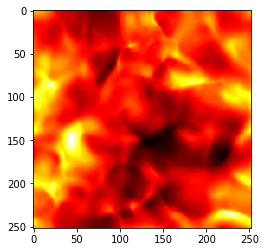

In [14]:
plt.imshow(sim_temp[:,:,3],cmap='hot')